In [478]:
import pandas as pd
import numpy as np
from datetime import datetime, time, timedelta
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, LabelEncoder
from scipy import stats
import shap

In [479]:
# Read in the data files
users = pd.read_csv('takehome_users.csv', encoding="ISO-8859-1")
user_engage = pd.read_csv('takehome_user_engagement.csv').sort_values('time_stamp').reset_index().drop('index', axis=1)

In [480]:
# Convert the time_stamp values to datetime objects
user_engage['time_stamp'] = pd.to_datetime(user_engage.time_stamp)

### Identify users who have logged in on three separate days in at least one seven day period

In [481]:
# Create a column with the number of logins per seven day period
def get_rolling_count(group, frequency):
    return group.rolling(frequency, on='time_stamp')['user_id'].count()

user_engage['visits_7_days'] = user_engage.groupby('user_id', as_index=False, group_keys=False).apply(get_rolling_count, '7D') 

In [482]:
# Create a column with ones and zeros indicating whether the user is an 'adopted user'
adopted = np.where(user_engage.visits_7_days >= 3, 1, 0)
user_engage['adopted'] = adopted

In [483]:
# rename the column so the dataframes can be merged
users = users.rename(columns={'object_id': 'user_id'}).drop(['name', 'email'], axis=1)

In [484]:
data = pd.merge(user_engage, users, on='user_id', how='outer').drop('visits_7_days', axis=1)

In [485]:
# Convert the datetime objects to float values so that they can be used in the model
data['time_stamp'] = pd.to_timedelta(data.time_stamp).dt.total_seconds()
data['creation_time'] = pd.to_timedelta(pd.to_datetime(data.creation_time)).dt.total_seconds()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [486]:
# Encode the creation source column so that it can be used in the model
data.creation_source = data.creation_source.astype('category')
data['creation_source'] = data.creation_source.cat.codes

In [487]:
import lightgbm as lgb

In [488]:
# Split the data and train the model
X = data.drop(['adopted'], axis=1)
y = data.adopted

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

lgb_train = lgb.Dataset(X_train, label=y_train, 
                        categorical_feature=['user_id','creation_source','org_id','invited_by_user_id'],
                        free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': 50,
        'colsample_bytree': 0.5,
        'subsample': 0.65,
        'n_estimators': 50,
        'learning_rate': 0.01,
        'reg_alpha': 0.01,
        'reg_lambda': 0.1
                }

model = lgb.train(params, lgb_train, 500)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [494]:
# Calculate the shap values to see how much impact each feature has on the model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

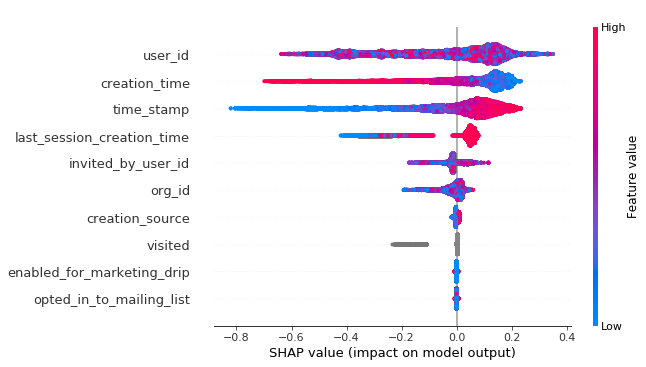

In [493]:
# Plot the shap values
shap.summary_plot(shap_values, X_test)

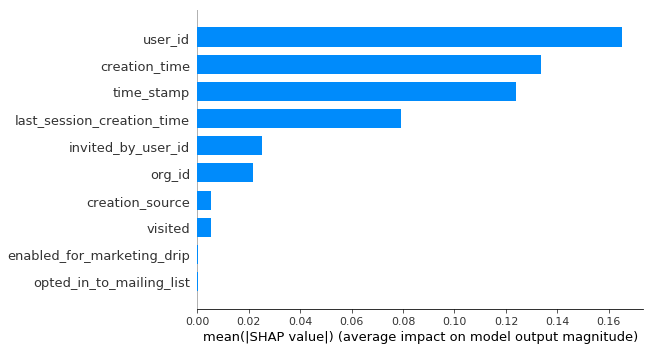

In [495]:
shap.summary_plot(shap_values, X, plot_type='bar')

### From the plot of the shap values, we can see that the best features for predicting user adoption are the user id, the time when they created their account, the time of last login, the user who invited them to join, and the organization they belong to.